In [14]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt

# random seedを設定
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [15]:
# 画像をテンソルに変換
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [16]:
from torch.utils.data import DataLoader, random_split

In [17]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10データセットのダウンロード
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# データの確認
print(f"訓練データ: {x_train.shape}, 訓練ラベル: {y_train.shape}")
print(f"テストデータ: {x_test.shape}, テストラベル: {y_test.shape}")


訓練データ: (50000, 32, 32, 3), 訓練ラベル: (50000, 1)
テストデータ: (10000, 32, 32, 3), テストラベル: (10000, 1)


In [18]:
full_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, transform=data_transform, download=True
)

# テストデータの取得
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, transform=data_transform, download=True
)

# 訓練データと検証データに分割 (8:2 の比率)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader の定義
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [19]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64  # ミニバッチサイズを設定、データセットのサイズによって自分で設定する
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
# ハードウェアの設定 
device = torch.device('mps')

ミニバッチサイズ:  torch.Size([64, 3, 32, 32])
画像のチャネル数:  3
画像の高さ:  32
画像の幅:  32


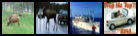

tensor([4, 4, 8, 1])


In [21]:
# ニューラルネットワークに入力する画像のサイズ、チャネル数をチェック
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("ミニバッチサイズ: ", images.size())
print("画像のチャネル数: ", c)
print("画像の高さ: ", h)
print("画像の幅: ", w)

# グリッド乗に4枚の画像を表示
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)

# 上の画像に対応するラベルを表示
print(labels[:4])

In [22]:
# ニューラルネットワークに入力する画像のサイズと分類するクラス数を定義
INPUT_CHANNELS = c
OUTPUT_SIZE = 10  # 分類するクラス数

# RestNet152をロード
model = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1")

# 最終層の出力ユニット数を変更
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, OUTPUT_SIZE)

# モデルをデバイスに転送
model = model.to(device)
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [23]:
# 多クラス分類のための損失関数を定義
criterion = nn.CrossEntropyLoss()

In [24]:
# モデルのパラメータを更新するための最適化手法をAdamで定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# モデルの学習
EPOCHS = 10
train_loss_list = []  # 訓練データの損失リスト
val_loss_list = []    # 検証データの損失リスト
train_acc_list = []   # 訓練データの精度リスト
val_acc_list = []     # 検証データの精度リスト

for epoch in range(EPOCHS):
    model.train()  # モデルを学習モードに設定
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # データをデバイスに転送
        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(images)  # モデルの出力を取得
        loss = criterion(outputs, labels)  # 損失を計算

        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新

        train_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）
        
        # 正解数を計算
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total  # データ数で割って平均を取る
    train_accuracy = 100 * train_correct / train_total  # 訓練データの精度計算
    train_loss_list.append(train_loss)  # 訓練損失をリストに追加
    train_acc_list.append(train_accuracy)  # 訓練精度をリストに追加

    model.eval()  # モデルを評価モードに設定
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # 評価時は勾配を計算しない
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # データをデバイスに転送

            outputs = model(images)  # モデルの出力を取得
            loss = criterion(outputs, labels)  # 損失を計算

            val_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）

            # 正解数を計算
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total  # データ数で割って平均を取る
    val_accuracy = 100 * val_correct / val_total  # 検証データの精度計算
    val_loss_list.append(val_loss)  # 検証損失をリストに追加
    val_acc_list.append(val_accuracy)  # 検証精度をリストに追加

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/10, Train Loss: 1.0132, Train Acc: 65.73%, Val Loss: 0.7665, Val Acc: 74.89%
Epoch 2/10, Train Loss: 0.7263, Train Acc: 75.75%, Val Loss: 0.6979, Val Acc: 76.00%
Epoch 3/10, Train Loss: 0.6241, Train Acc: 78.92%, Val Loss: 0.6093, Val Acc: 79.19%
Epoch 4/10, Train Loss: 0.7780, Train Acc: 74.67%, Val Loss: 0.9908, Val Acc: 65.00%
Epoch 5/10, Train Loss: 0.9299, Train Acc: 69.29%, Val Loss: 0.7508, Val Acc: 73.73%
Epoch 6/10, Train Loss: 0.8150, Train Acc: 72.79%, Val Loss: 0.7693, Val Acc: 73.98%
Epoch 7/10, Train Loss: 0.7819, Train Acc: 73.82%, Val Loss: 0.7759, Val Acc: 73.77%
Epoch 8/10, Train Loss: 0.8573, Train Acc: 70.65%, Val Loss: 0.7234, Val Acc: 75.61%
Epoch 9/10, Train Loss: 0.6626, Train Acc: 77.63%, Val Loss: 0.6693, Val Acc: 78.11%
Epoch 10/10, Train Loss: 0.5649, Train Acc: 80.48%, Val Loss: 0.5700, Val Acc: 80.65%


Confusion Matrix:
[[824  23  21  13  11   3   3   8  62  24]
 [ 13 952   3   4   2   3  10   2  15  45]
 [ 76   2 753  38  50  24  63   9  11   7]
 [ 21   4  51 585  36 141  70  16  15   4]
 [ 26   3  57  39 771  18  38  32   5   2]
 [  6   1  47 156  29 728  16  41   5   7]
 [  5   3  33  20  15  12 886   1   1   1]
 [ 18   4  15  37  48  25   3 804   1   4]
 [ 30  31   7   8   5   6   4   2 891  22]
 [ 21  66   8   8   0   4  10   4  22 871]]


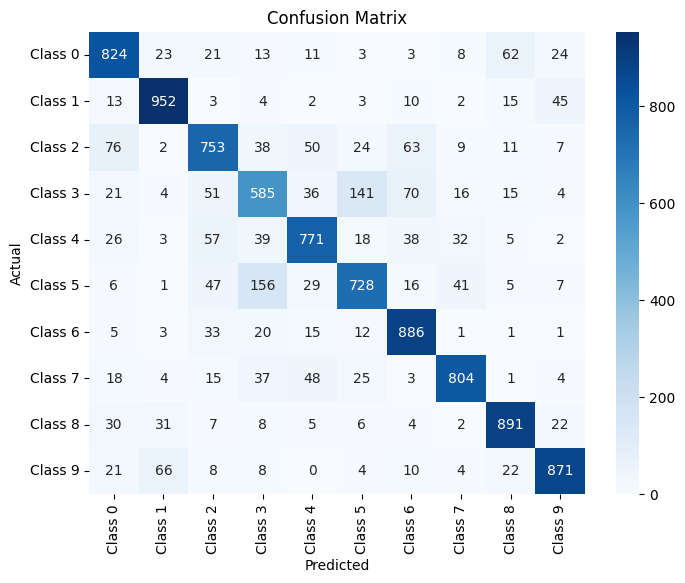

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.83      0.81       992
     Class 1       0.87      0.91      0.89      1049
     Class 2       0.76      0.73      0.74      1033
     Class 3       0.64      0.62      0.63       943
     Class 4       0.80      0.78      0.79       991
     Class 5       0.76      0.70      0.73      1036
     Class 6       0.80      0.91      0.85       977
     Class 7       0.87      0.84      0.86       959
     Class 8       0.87      0.89      0.88      1006
     Class 9       0.88      0.86      0.87      1014

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.81      0.81      0.81     10000



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 検証データでの推論
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader: 検証データのDataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# クラス名とラベルを一致させる
unique_labels = sorted(set(all_labels))  # 出現するクラスラベルを取得
if 'class_names' not in globals() or len(class_names) != len(unique_labels):
    class_names = [f"Class {i}" for i in unique_labels]  # 自動生成（例: "Class 0", "Class 1", ...）

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1スコアのレポート
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [26]:
# モデルの評価
model.eval() # モデルを評価モードに設定
correct = 0 # 正解数
total = 0 # テストデータの総数
with torch.no_grad():
    for images, labels in test_loader: # テストデータを取得
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        outputs = model(images) # 画像をモデルに入力して出力を取得
        _, predicted = torch.max(outputs, 1) # 確率が最大のラベルを取得=モデルによる予測結果を取得
        total += labels.size(0) # labels.size(0)はミニバッチサイズ、毎回加算することでテストデータの総数を計算
        correct += (predicted == labels).sum().item() # 予測と正解ラベルが一致した場合に正解数をカウント
# 正解率を%で表示
print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 79.48%
